## Import your stuff

In [1]:
import numpy as np
import pandas as pd
import emcee
from scipy.optimize import minimize
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import matplotlib as mpl
import simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 1

## Set up the prior

In [2]:
upper = np.array([12,  12,
  12,  12, -2, -2, -2,
 -2])
lower = np.array([6,  6,
  6,  6, -8, -8, -8,
 -8])

prior_mean = np.array([1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([(0.0011*0.2)**2, (0.39*0.2)**2]))

prior = priors.Gaussian_Unif(prior_mean, prior_cov, lower, upper, 2)

epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.5] * 94))
epsilon_prior = priors.Gaussian(epsilon_mean, epsilon_cov)

#print(faasSimulator.exp(1))

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [3]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(th, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.draw()
    #eps.index = ['epsilon' + str(i) for i in np.arange(0,94)]
    #eps = [0] * 94
    
    
    return faasSimulator.simulation(np.concatenate([th, eps]), seed)

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0

theta_f = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01]

# #th = [7.41182866e+00,  1.08261090e+01,  1.17609716e+01,  1.18367247e+01
#  -3.77631101e+00, -5.19751189e+00, -4.17913301e+00, -5.19552395e+00,
#   1.41581953e-03, -3.82868255e-01]
print(simulator(theta_f, 0, simulator_args, 1))


[ 1.34730079  1.84390558  0.236       1.62004847  2.34246299  1.556
  2.39117874  3.41555344  1.456       1.68996837  2.44725395  1.54
  3.14791604  4.29860278  1.312      12.50003697 12.5001967   9.096
 11.8140486  11.81410351 22.004       4.1809864   5.32743269  1.216
 13.13937887 13.13937942 11.06        5.13126167  6.13416297  1.132
 12.41994604 12.4209586  24.204       8.4779455   8.47805387 11.06
 13.07091332 13.07091613 15.408       2.80284706  4.54835111  1.252
  3.01415222  4.82708762  1.252       1.60235322  2.52053094  1.372
  2.19406557  3.58842321  1.3         2.38196763  3.90104967  1.288
 15.14651917 15.14651928 39.604       2.40976241  3.94699905  1.288
  9.5204041  10.78560707  1.072       6.83823246  8.95336397  1.072
  5.96307792  8.179749    1.096      11.5795391  11.94143264  1.24
  2.69254029  4.37564195  1.372       5.6158201   8.00700385  1.24
  5.56270503  7.95165556  1.24        8.10550661 10.2891755   1.204
 12.97137802 13.56564657  1.288       7.10220198  9.

In [ ]:
# theta_fiducial = np.array([8.886491e+00,  7.924279e+00,
#   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
#  -6.585027e+00,  1.100000e-03, -3.900000e-01])
# eta_fiducial = np.array(np.load('epsfid.npy'))

# Cinv = faasSimulator.Cinv
# #np.save('Finv.npy', Finv) # save Finv
# mu = np.load('mu.npy') # save mu
# #np.save('Cinv.npy', Cinv) # save Cinv
# dmudt = np.load('dmudt.npy') # save dmudt


# Compressor = score.Gaussian(len(faasSimulator.data()[0,:]), np.concatenate([theta_fiducial, eta_fiducial]), 
#                             mu = mu, Cinv = Cinv, dmudt = dmudt)

# Compressor.compute_fisher()
# Finv = Compressor.Finv[0:10,0:10]

# nuisance_indices = np.arange(10,104)

# def compressor(d, compressor_args):
#     nuisances_indices = compressor_args[0]
#     return Compressor.projected_scoreMLE(d, nuisance_indices)
# compressor_args = [nuisance_indices]

## Set up the compressor
This must have the signature `compressor(data, args)` -> `np.array([n_summaries])`
In this case we are going to do _nuisance hardened_ Gaussian score compression $$\bar{\mathbf{t}}_\theta = \mathbf{t}_\theta - \mathbf{F}_{\theta\eta}\mathbf{F}^{-1}_{\eta\eta}\mathbf{t}_\eta$$ where $$\mathbf{t}_{(\theta, \eta)} = \nabla_{(\theta, \eta)}^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$
We'll use the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
theta_fiducial = np.array([8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100000e-03, -3.900000e-01])
eta_fiducial = [0.1] * 94
#print(eta_fiducial)
mu = faasSimulator.simulation(np.concatenate([theta_fiducial, eta_fiducial]), seed)
Cinv = faasSimulator.Cinv
print(Cinv.shape)

h = np.array(abs(np.concatenate([theta_fiducial, eta_fiducial])))*0.01
dmudt = faasSimulator.dmudt(np.concatenate([theta_fiducial, eta_fiducial]), h)
print(dmudt.shape)
Compressor = score.Gaussian(len(faasSimulator.data()[0,:]), np.concatenate([theta_fiducial, eta_fiducial]), 
                            mu = mu, Cinv = Cinv, dmudt = dmudt)

Compressor.compute_fisher()
Finv = Compressor.Finv[0:10,0:10]

nuisance_indices = np.arange(10,104)

def compressor(d, compressor_args):
    nuisances_indices = compressor_args[0]
    return Compressor.projected_scoreMLE(d, nuisance_indices)
compressor_args = [nuisance_indices]

(282, 282)
(104, 282)


## Load in the compressed data

In [5]:
compressed_data = compressor(faasSimulator.data_comp(), compressor_args)
print(compressed_data)
n_data = len(compressed_data)

[ 8.84693319e+00  7.87193946e+00  1.04668244e+01  7.60554193e+00
 -3.66810304e+00 -4.46340453e+00 -6.15641698e+00 -6.59143228e+00
  1.09671346e-03 -3.88028524e-01]


## Load in data

## Save FINV, only worth doing once, make sure to load

In [ ]:
# np.save('Finv.npy', Finv) # save Finv
# np.save('mu.npy', mu) # save mu
# #np.save('Cinv.npy', Cinv) # save Cinv
# np.save('dmudt.npy', dmudt) # save dmudt

In [ ]:
# data = faasSimulator.data()[0]

## Define ensemble of NDEs

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=10, n_data=n_data, n_hiddens=[50,50], n_mades=8, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, Finv = None, theta_fiducial = theta_fiducial,
                       param_limits = [np.concatenate((lower, [(0.0011-(0.0011*0.8)**2),(-0.39-(0.39*0.8)**2)])), np.concatenate((upper, [(0.0011+(0.0011*0.8)**2),(-0.39+(0.39*0.8)**2)]))],
                       param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
                       results_dir = "results/",input_normalization = None, restore = False, save = True, nwalkers = 750)

In [ ]:
# DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
#                        param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
#                        results_dir = "results_batch_whole_comp/", restore = False, save = True)

## Fisher pre-training to initialize the NDEs

In [ ]:
DelfiEnsemble.fisher_pretraining(plot=False)

## Sequential Neural Likelihood

Simulator returns NaN/inf for parameter values: [ 7.43305319e+00  8.77139195e+00  1.15862166e+01  6.41008057e+00
 -3.43007708e+00 -6.68256896e+00 -5.30781872e+00 -7.79776952e+00
  8.28456038e-04 -2.98063388e-01] (rank 0)
Data Samples
[[ 8.85830867e+00  7.86680363e+00  1.04771007e+01 ... -6.56200451e+00
   1.09461855e-03 -3.87998286e-01]
 [ 8.86080637e+00  7.89833083e+00  1.04759662e+01 ... -6.58434562e+00
   1.09663147e-03 -3.88116111e-01]
 [ 8.84956668e+00  7.86318629e+00  1.04853904e+01 ... -6.58426440e+00
   1.09630682e-03 -3.87648695e-01]
 ...
 [ 8.90007419e+00  8.03695448e+00  1.04984084e+01 ... -6.64057871e+00
   1.10022976e-03 -3.92454501e-01]
 [ 8.87758016e+00  7.94186418e+00  1.05445252e+01 ... -6.57430993e+00
   1.09947960e-03 -3.90686327e-01]
 [ 8.87508084e+00  8.01618434e+00  1.05599345e+01 ... -6.65116884e+00
   1.10068842e-03 -3.90709647e-01]]
Parameter Samples
[[ 6.91845668e+00  9.38132227e+00  7.48104166e+00 ... -3.57459626e+00
   8.88743409e-04 -3.68813294e-01]
 [ 7.08

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Population 1/31
Sampling proposal density...
Done.


Data Samples
[[ 8.86032273e+00  7.92585669e+00  1.04802160e+01 ... -6.58598314e+00
   1.09589700e-03 -3.89896291e-01]
 [ 8.88914719e+00  7.83802133e+00  1.05121008e+01 ... -6.50079543e+00
   1.10038510e-03 -3.85845237e-01]
 [ 8.89657662e+00  7.95183840e+00  1.05065726e+01 ... -6.60579210e+00
   1.10055634e-03 -3.92210073e-01]
 ...
 [ 8.89542151e+00  7.95315182e+00  1.05179393e+01 ... -6.66671939e+00
   1.10283482e-03 -3.95164866e-01]
 [ 8.86814621e+00  7.94168476e+00  1.05358712e+01 ... -6.62250296e+00
   1.10308523e-03 -3.87802356e-01]
 [ 8.86599731e+00  8.00946536e+00  1.04973851e+01 ... -6.60704253e+00
   1.09450973e-03 -3.89694413e-01]]
Parameter Samples
[[ 7.24820766e+00  1.02813306e+01  9.69140214e+00 ... -6.20741433e+00
   1.09083619e-03 -4.52999640e-01]
 [ 7.24820766e+00  1.02813306e+01  9.69140214e+00 ... -6.20741433e+00
   1.09083619e-03 -4.52999640e-01]
 [ 7.24820766e+00  1.02813306e+01  9.69140214e+00 ... -6.20741433e+00
   1.09083619e-03 -4.52999640e-01]
 ...
 [ 6.54280382

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

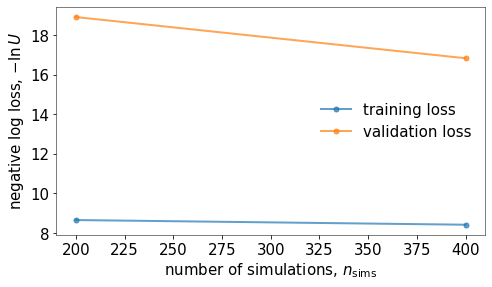

Population 2/31
Sampling proposal density...
Done.


Data Samples
[[ 8.91806721e+00  7.95308198e+00  1.05334979e+01 ... -6.60302061e+00
   1.09741095e-03 -3.92682842e-01]
 [ 8.90118296e+00  7.93171778e+00  1.05421968e+01 ... -6.54980792e+00
   1.09531901e-03 -3.91056188e-01]
 [ 8.88388387e+00  7.94403054e+00  1.05545728e+01 ... -6.52355644e+00
   1.09787146e-03 -3.90989498e-01]
 ...
 [ 8.90232698e+00  7.84456329e+00  1.05370938e+01 ... -6.51323570e+00
   1.09833426e-03 -3.89333851e-01]
 [ 8.92161033e+00  7.88103513e+00  1.05131071e+01 ... -6.57800203e+00
   1.10566605e-03 -3.90020208e-01]
 [ 8.82680958e+00  7.93497175e+00  1.05179326e+01 ... -6.60932927e+00
   1.09609023e-03 -3.87115803e-01]]
Parameter Samples
[[ 1.09313092e+01  7.20632304e+00  1.12934492e+01 ... -6.67691015e+00
   9.39774044e-04 -4.41585644e-01]
 [ 1.09313092e+01  7.20632304e+00  1.12934492e+01 ... -6.67691015e+00
   9.39774044e-04 -4.41585644e-01]
 [ 1.09313092e+01  7.20632304e+00  1.12934492e+01 ... -6.67691015e+00
   9.39774044e-04 -4.41585644e-01]
 ...
 [ 8.82056483

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

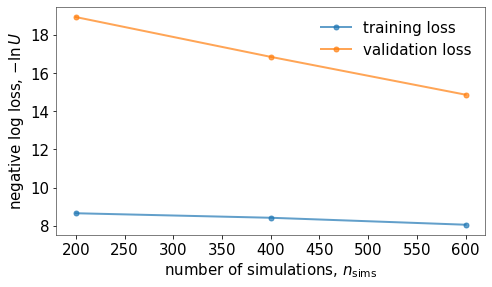

Population 3/31
Sampling proposal density...
Done.


Data Samples
[[ 8.84081464e+00  7.86561720e+00  1.04750341e+01 ... -6.60144877e+00
   1.09730552e-03 -3.88425563e-01]
 [ 8.84808589e+00  7.86287665e+00  1.04698557e+01 ... -6.57921161e+00
   1.09702630e-03 -3.87531587e-01]
 [ 8.85397685e+00  7.86102950e+00  1.04652556e+01 ... -6.57875319e+00
   1.09553896e-03 -3.86892495e-01]
 ...
 [ 8.86586609e+00  7.93439338e+00  1.05338661e+01 ... -6.59604827e+00
   1.09666714e-03 -3.88933972e-01]
 [ 8.87208986e+00  7.83836460e+00  1.04834358e+01 ... -6.54184752e+00
   1.10764959e-03 -3.85357679e-01]
 [ 8.92969094e+00  7.94906452e+00  1.05242190e+01 ... -6.59549477e+00
   1.09995927e-03 -3.88087003e-01]]
Parameter Samples
[[ 1.00972291e+01  7.80318926e+00  9.24149667e+00 ... -5.83883034e+00
   6.46243456e-04 -4.47488036e-01]
 [ 1.00972291e+01  7.80318926e+00  9.24149667e+00 ... -5.83883034e+00
   6.46243456e-04 -4.47488036e-01]
 [ 1.00972291e+01  7.80318926e+00  9.24149667e+00 ... -5.83883034e+00
   6.46243456e-04 -4.47488036e-01]
 ...
 [ 1.18950396

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

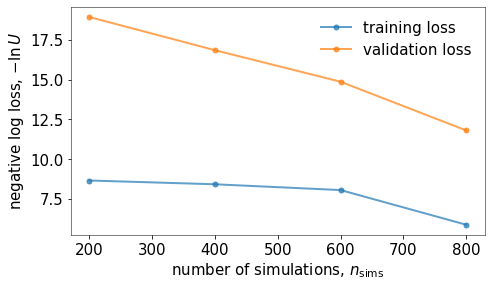

Population 4/31
Sampling proposal density...
Done.


Data Samples
[[ 8.83467373e+00  7.94180867e+00  1.05107577e+01 ... -6.63123299e+00
   1.10266970e-03 -3.90932185e-01]
 [ 8.90694618e+00  7.86235763e+00  1.04861673e+01 ... -6.57241258e+00
   1.10632803e-03 -3.89729551e-01]
 [ 8.85089547e+00  7.92171031e+00  1.04754003e+01 ... -6.55551273e+00
   1.09846190e-03 -3.88659752e-01]
 ...
 [ 8.84109492e+00  7.85301753e+00  1.04528636e+01 ... -6.57797662e+00
   1.09486265e-03 -3.86296752e-01]
 [ 8.83202668e+00  7.85273148e+00  1.04636975e+01 ... -6.58978310e+00
   1.10706499e-03 -3.88663227e-01]
 [ 8.84742842e+00  7.86017438e+00  1.04706216e+01 ... -6.58059706e+00
   1.09658094e-03 -3.87646384e-01]]
Parameter Samples
[[ 7.35194663e+00  6.56543539e+00  6.10142698e+00 ... -5.86130904e+00
   1.12137944e-03 -3.58373458e-01]
 [ 7.35194663e+00  6.56543539e+00  6.10142698e+00 ... -5.86130904e+00
   1.12137944e-03 -3.58373458e-01]
 [ 7.35194663e+00  6.56543539e+00  6.10142698e+00 ... -5.86130904e+00
   1.12137944e-03 -3.58373458e-01]
 ...
 [ 1.06929712

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

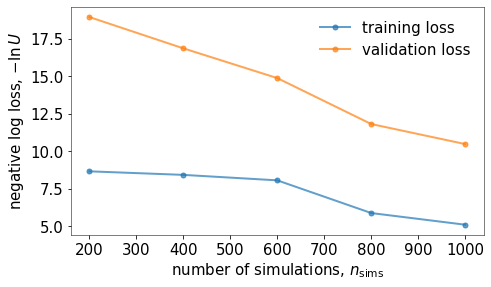

Population 5/31
Sampling proposal density...
Done.


Simulator returns NaN/inf for parameter values: [ 1.11894237e+01  9.08634755e+00  6.80938489e+00  9.67109591e+00
 -6.18386986e+00 -2.38134636e+00 -6.77291161e+00 -4.98927057e+00
  8.79159442e-04 -4.10641210e-01] (rank 0)
Data Samples
[[ 8.86165758e+00  7.88117411e+00  1.04795186e+01 ... -6.58730513e+00
   1.09687765e-03 -3.87472197e-01]
 [ 8.87554351e+00  7.87830388e+00  1.04845507e+01 ... -6.57270762e+00
   1.09649265e-03 -3.88099642e-01]
 [ 8.86423713e+00  7.87497720e+00  1.04794517e+01 ... -6.57277844e+00
   1.09713420e-03 -3.87662858e-01]
 ...
 [ 8.84747366e+00  7.85803210e+00  1.04717833e+01 ... -6.58059380e+00
   1.09651728e-03 -3.87662535e-01]
 [ 8.91014018e+00  7.96094269e+00  1.05153973e+01 ... -6.63045473e+00
   1.08954688e-03 -3.92123517e-01]
 [ 8.93754013e+00  7.99583073e+00  1.05754782e+01 ... -6.61280355e+00
   1.10603697e-03 -3.92503855e-01]]
Parameter Samples
[[ 1.08335656e+01  9.13815878e+00  6.34790852e+00 ... -4.93546492e+00
   8.64820848e-04 -3.87965187e-01]
 [ 1.08

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

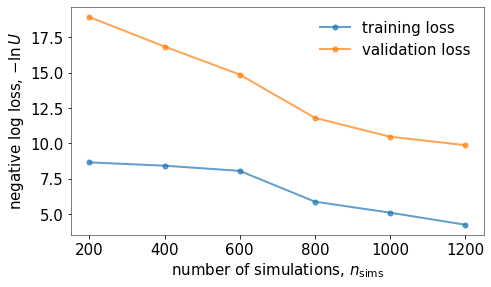

Population 6/31
Sampling proposal density...
Done.


Data Samples
[[ 8.89548372e+00  7.84253010e+00  1.05840923e+01 ... -6.56856860e+00
   1.10141339e-03 -3.89923268e-01]
 [ 8.83400209e+00  7.90640005e+00  1.05506303e+01 ... -6.64653766e+00
   1.11041520e-03 -3.87892462e-01]
 [ 8.89627026e+00  7.91615761e+00  1.05474217e+01 ... -6.57317694e+00
   1.11186043e-03 -3.89602161e-01]
 ...
 [ 8.90648855e+00  7.98815414e+00  1.04810023e+01 ... -6.57478018e+00
   1.10978446e-03 -3.92392458e-01]
 [ 8.82318692e+00  8.10985425e+00  1.06182935e+01 ... -6.73059740e+00
   1.09121277e-03 -3.92629428e-01]
 [ 8.87450541e+00  8.03251094e+00  1.06146304e+01 ... -6.64357675e+00
   1.09869738e-03 -3.91418972e-01]]
Parameter Samples
[[ 1.03176859e+01  1.00349172e+01  6.63678076e+00 ... -2.15042792e+00
   7.96735904e-04 -4.76967430e-01]
 [ 1.03626352e+01  1.02198895e+01  6.60373973e+00 ... -2.29606721e+00
   8.05274568e-04 -4.68898408e-01]
 [ 1.03626352e+01  1.02198895e+01  6.60373973e+00 ... -2.29606721e+00
   8.05274568e-04 -4.68898408e-01]
 ...
 [ 6.89769184

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

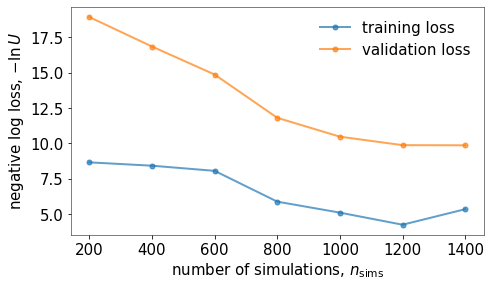

Population 7/31
Sampling proposal density...
Done.


Data Samples
[[ 8.90182289e+00  7.92322970e+00  1.04785255e+01 ... -6.62778830e+00
   1.09984876e-03 -3.91121967e-01]
 [ 8.89928012e+00  7.92335182e+00  1.04800493e+01 ... -6.62595690e+00
   1.10003356e-03 -3.90853382e-01]
 [ 8.90183771e+00  7.92775776e+00  1.04774409e+01 ... -6.62774867e+00
   1.09992774e-03 -3.91211786e-01]
 ...
 [ 8.86817886e+00  7.90815979e+00  1.04253194e+01 ... -6.58525960e+00
   1.10676622e-03 -3.88501594e-01]
 [ 8.86758827e+00  7.90892622e+00  1.04250998e+01 ... -6.58484719e+00
   1.10678652e-03 -3.88487973e-01]
 [ 8.87014034e+00  7.91443702e+00  1.04262745e+01 ... -6.58659057e+00
   1.10621765e-03 -3.88561621e-01]]
Parameter Samples
[[ 1.06970435e+01  7.54161615e+00  7.57190374e+00 ... -5.12586492e+00
   9.40126450e-04 -4.90658733e-01]
 [ 1.06970435e+01  7.54161615e+00  7.57190374e+00 ... -5.12586492e+00
   9.40126450e-04 -4.90658733e-01]
 [ 1.06970435e+01  7.54161615e+00  7.57190374e+00 ... -5.12586492e+00
   9.40126450e-04 -4.90658733e-01]
 ...
 [ 1.17792281

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

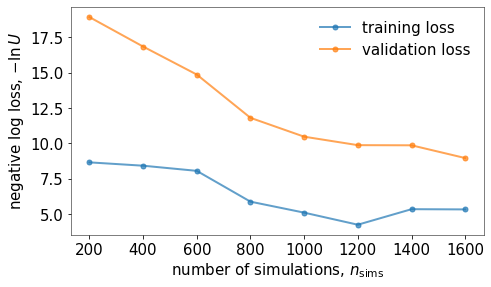

Population 8/31
Sampling proposal density...
Done.


Data Samples
[[ 8.84451127e+00  7.85030779e+00  1.04670407e+01 ... -6.57639133e+00
   1.09645783e-03 -3.87430049e-01]
 [ 8.84125105e+00  7.95519144e+00  1.05055932e+01 ... -6.61969874e+00
   1.09645167e-03 -3.89297016e-01]
 [ 8.85149395e+00  7.96032186e+00  1.05450470e+01 ... -6.63129094e+00
   1.09333697e-03 -3.89769969e-01]
 ...
 [ 8.94833009e+00  8.08047809e+00  1.05940391e+01 ... -6.63552411e+00
   1.10746150e-03 -3.93546306e-01]
 [ 8.94133127e+00  8.08267813e+00  1.05904608e+01 ... -6.64137028e+00
   1.10717652e-03 -3.93760157e-01]
 [ 8.90850553e+00  8.04322410e+00  1.05702094e+01 ... -6.72611624e+00
   1.10683516e-03 -3.92139253e-01]]
Parameter Samples
[[ 1.01822953e+01  7.82497169e+00  7.73873701e+00 ... -5.21055830e+00
   9.27381158e-04 -4.73213690e-01]
 [ 1.08153259e+01  8.32654105e+00  7.92447180e+00 ... -5.38175180e+00
   9.83230755e-04 -4.58659125e-01]
 [ 1.08153259e+01  8.32654105e+00  7.92447180e+00 ... -5.38175180e+00
   9.83230755e-04 -4.58659125e-01]
 ...
 [ 1.17547226

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

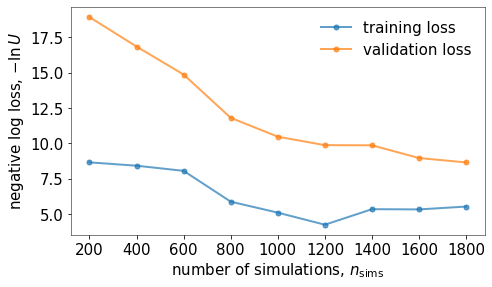

Population 9/31
Sampling proposal density...
Done.


Simulator returns NaN/inf for parameter values: [ 1.03285789e+01  7.50682318e+00  6.13489188e+00  9.67841846e+00
 -4.69432129e+00 -3.89156571e+00 -6.54801094e+00 -3.63547650e+00
  1.03850489e-03 -3.94191276e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 1.03514411e+01  7.53591807e+00  6.13404177e+00  9.63287653e+00
 -4.57643223e+00 -3.97464850e+00 -6.54404268e+00 -3.56723004e+00
  1.05344671e-03 -3.95293213e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 1.03514411e+01  7.53591807e+00  6.13404177e+00  9.63287653e+00
 -4.57643223e+00 -3.97464850e+00 -6.54404268e+00 -3.56723004e+00
  1.05344671e-03 -3.95293213e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 1.03514411e+01  7.53591807e+00  6.13404177e+00  9.63287653e+00
 -4.57643223e+00 -3.97464850e+00 -6.54404268e+00 -3.56723004e+00
  1.05344671e-03 -3.95293213e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 1.03514411e+01  7.53591807e+00  6.13404177e+00  9.63287653e+00
 -4

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

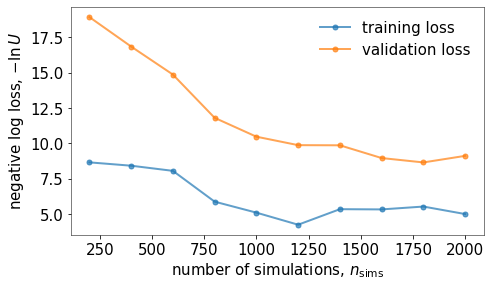

Population 10/31
Sampling proposal density...
Done.


Simulator returns NaN/inf for parameter values: [ 6.88685112e+00  6.41587336e+00  9.83403759e+00  1.16135162e+01
 -5.58459146e+00 -6.14203926e+00 -6.28032553e+00 -6.96829787e+00
  8.91687132e-04 -3.16493545e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 6.88685112e+00  6.41587336e+00  9.83403759e+00  1.16135162e+01
 -5.58459146e+00 -6.14203926e+00 -6.28032553e+00 -6.96829787e+00
  8.91687132e-04 -3.16493545e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 8.28886556e+00  6.51320170e+00  1.07649018e+01  1.15765157e+01
 -5.05698545e+00 -6.17291608e+00 -4.73868082e+00 -7.26759997e+00
  8.59935878e-04 -4.03076053e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 8.28886556e+00  6.51320170e+00  1.07649018e+01  1.15765157e+01
 -5.05698545e+00 -6.17291608e+00 -4.73868082e+00 -7.26759997e+00
  8.59935878e-04 -4.03076053e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 8.17839398e+00  6.19295469e+00  9.99459434e+00  1.15976554e+01
 -4

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

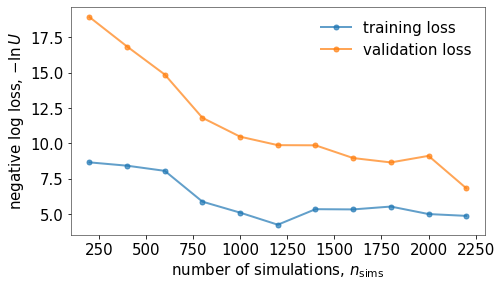

Population 11/31
Sampling proposal density...
Done.


Data Samples
[[ 8.81843373e+00  7.90646152e+00  1.05612474e+01 ... -6.57910414e+00
   1.10355555e-03 -3.87483725e-01]
 [ 8.84725428e+00  7.92313169e+00  1.05500491e+01 ... -6.57042796e+00
   1.10080180e-03 -3.91202008e-01]
 [ 8.86721615e+00  7.91146032e+00  1.05362298e+01 ... -6.50965586e+00
   1.09965758e-03 -3.88911460e-01]
 ...
 [ 8.95215033e+00  7.97984686e+00  1.04686334e+01 ... -6.61579527e+00
   1.10283453e-03 -3.92089069e-01]
 [ 8.95241852e+00  8.03911265e+00  1.04916018e+01 ... -6.63839776e+00
   1.09877136e-03 -3.93336177e-01]
 [ 8.91807697e+00  7.98691131e+00  1.04831621e+01 ... -6.63386149e+00
   1.10005732e-03 -3.92121223e-01]]
Parameter Samples
[[ 8.47937193e+00  7.15520973e+00  6.01778221e+00 ... -2.82142171e+00
   6.72469238e-04 -4.06931489e-01]
 [ 8.47937193e+00  7.15520973e+00  6.01778221e+00 ... -2.82142171e+00
   6.72469238e-04 -4.06931489e-01]
 [ 8.47937193e+00  7.15520973e+00  6.01778221e+00 ... -2.82142171e+00
   6.72469238e-04 -4.06931489e-01]
 ...
 [ 6.07872693

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

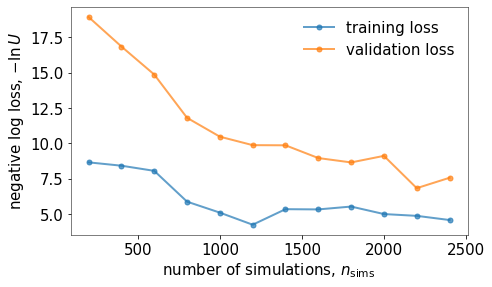

Population 12/31
Sampling proposal density...
Done.


Data Samples
[[ 8.84868286e+00  7.85961005e+00  1.04723384e+01 ... -6.58529573e+00
   1.09629213e-03 -3.87672056e-01]
 [ 8.83291416e+00  7.85321468e+00  1.04637255e+01 ... -6.59093239e+00
   1.10688228e-03 -3.88737304e-01]
 [ 8.84758025e+00  7.86006467e+00  1.04704891e+01 ... -6.58324095e+00
   1.09606831e-03 -3.87672895e-01]
 ...
 [ 8.84410557e+00  7.85131347e+00  1.04657121e+01 ... -6.57860425e+00
   1.09668415e-03 -3.87466038e-01]
 [ 8.84169539e+00  7.85623878e+00  1.04633266e+01 ... -6.58114699e+00
   1.09684602e-03 -3.87605469e-01]
 [ 8.84380091e+00  7.85259871e+00  1.04651757e+01 ... -6.57862898e+00
   1.09663387e-03 -3.87431038e-01]]
Parameter Samples
[[ 1.01218671e+01  6.45682349e+00  8.37543109e+00 ... -6.55307646e+00
   9.45118883e-04 -4.66230473e-01]
 [ 1.01218671e+01  6.45682349e+00  8.37543109e+00 ... -6.55307646e+00
   9.45118883e-04 -4.66230473e-01]
 [ 1.01218671e+01  6.45682349e+00  8.37543109e+00 ... -6.55307646e+00
   9.45118883e-04 -4.66230473e-01]
 ...
 [ 1.01239611

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

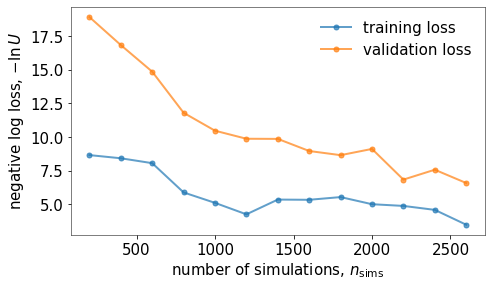

Population 13/31
Sampling proposal density...
Done.


Data Samples
[[ 8.87211207e+00  7.89151482e+00  1.04990228e+01 ... -6.56393806e+00
   1.09753731e-03 -3.89272605e-01]
 [ 8.85769074e+00  7.92121324e+00  1.04701034e+01 ... -6.59613292e+00
   1.09439512e-03 -3.88822289e-01]
 [ 8.90441858e+00  7.87501841e+00  1.04500374e+01 ... -6.53366450e+00
   1.09411903e-03 -3.85649599e-01]
 ...
 [ 8.88097272e+00  7.93320016e+00  1.05119404e+01 ... -6.53999406e+00
   1.10074077e-03 -3.90049930e-01]
 [ 8.90783311e+00  7.91146637e+00  1.04772872e+01 ... -6.56724467e+00
   1.09776340e-03 -3.90005741e-01]
 [ 8.86165464e+00  7.94616761e+00  1.05001730e+01 ... -6.53755732e+00
   1.10075622e-03 -3.87939017e-01]]
Parameter Samples
[[ 1.10439694e+01  7.01643380e+00  9.77826276e+00 ... -6.74679136e+00
   1.04398876e-03 -3.91396214e-01]
 [ 1.10439694e+01  7.01643380e+00  9.77826276e+00 ... -6.74679136e+00
   1.04398876e-03 -3.91396214e-01]
 [ 1.10439694e+01  7.01643380e+00  9.77826276e+00 ... -6.74679136e+00
   1.04398876e-03 -3.91396214e-01]
 ...
 [ 1.10341199

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

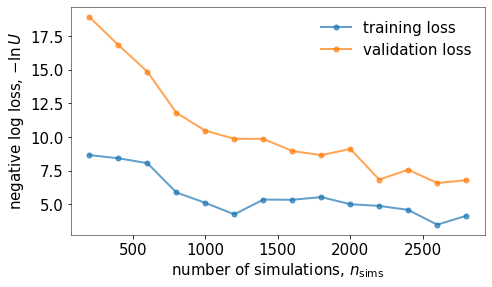

Population 14/31
Sampling proposal density...
Done.


Data Samples
[[ 8.81686450e+00  7.90180684e+00  1.04845994e+01 ... -6.60780268e+00
   1.09665000e-03 -3.88526011e-01]
 [ 8.83340976e+00  7.87123400e+00  1.04950378e+01 ... -6.57382440e+00
   1.09618508e-03 -3.88258515e-01]
 [ 8.89640716e+00  7.86150861e+00  1.04619944e+01 ... -6.53963861e+00
   1.10180379e-03 -3.89121448e-01]
 ...
 [ 8.85750184e+00  7.92137334e+00  1.04903284e+01 ... -6.60720132e+00
   1.09891762e-03 -3.88136829e-01]
 [ 8.85943895e+00  7.87949628e+00  1.04963291e+01 ... -6.60504808e+00
   1.09868939e-03 -3.89109318e-01]
 [ 8.85433139e+00  7.87669797e+00  1.04828195e+01 ... -6.59149161e+00
   1.09776103e-03 -3.88685542e-01]]
Parameter Samples
[[ 8.64294672e+00  1.08554886e+01  8.76562253e+00 ... -3.44088597e+00
   8.57911047e-04 -4.17190045e-01]
 [ 9.05278249e+00  1.04459613e+01  8.56488693e+00 ... -3.94119989e+00
   8.87917043e-04 -4.27997618e-01]
 [ 9.05278249e+00  1.04459613e+01  8.56488693e+00 ... -3.94119989e+00
   8.87917043e-04 -4.27997618e-01]
 ...
 [ 7.55595507

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , 16.21080399, 15.71168041,
       15.29197598, 14.94061947, 14.64641476, 14.39556503, 14.17900372,
       13.99035549, 13.82434654, 13.67609882, 13.54170227, 13.41817665,
       13.30335999, 13.19552994, 13.09373665, 12.99530888, 12.90166378,
       12.81058502, 12.72148705, 12.63519382, 12.55198574, 12.47141933,
       12.3928051 , 12.3162384 , 12.2422266 , 12.17029476, 12.10076809,
       12.03211308, 11.96402836, 11.89709091, 11.83089447, 11.76407623,
       11.69769669, 11.63167953, 11.56533051, 11.49895191, 11.43332386,
       11.36823559, 11.30450344, 11.2419529 , 11.17982769, 11.11892223,
       11.0582571 , 10.99810696, 10.93851089, 10.8801136 , 10.82288551,
       10.76681423, 10.71183109, 10.65581703, 10.60017681, 10.54453754,
       10.48908806, 10.43296719, 10.37692642, 10.32091713, 10.2647028 ,
       10.20924568, 10.15525532, 10.10182095, 10.04813194,  9.99397373,
        9.94043255,  9.88739395,  9.83521366,  9.

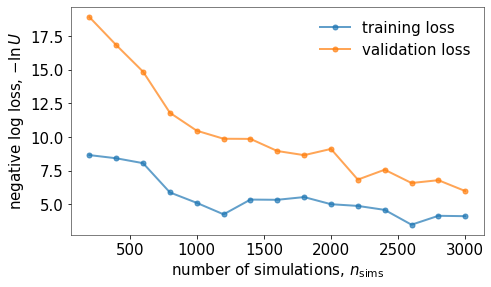

Population 15/31
Sampling proposal density...
Done.


Data Samples
[[ 8.95082308e+00  7.88552912e+00  1.04978565e+01 ... -6.58069933e+00
   1.10168689e-03 -3.90236579e-01]
 [ 8.87811496e+00  7.90048338e+00  1.04974760e+01 ... -6.53418982e+00
   1.10298251e-03 -3.89070844e-01]
 [ 8.84010721e+00  7.91952288e+00  1.05131198e+01 ... -6.57973692e+00
   1.09964154e-03 -3.89044645e-01]
 ...
 [ 8.84284953e+00  7.89472213e+00  1.04759447e+01 ... -6.58371777e+00
   1.09678495e-03 -3.87613025e-01]
 [ 8.86899299e+00  7.89226455e+00  1.04836307e+01 ... -6.58028876e+00
   1.09641946e-03 -3.88463198e-01]
 [ 8.86179046e+00  7.86501249e+00  1.04761364e+01 ... -6.58250037e+00
   1.09743401e-03 -3.88131804e-01]]
Parameter Samples
[[ 1.08553710e+01  1.04700029e+01  6.57533568e+00 ... -3.93167413e+00
   1.13931266e-03 -4.56011077e-01]
 [ 1.08553710e+01  1.04700029e+01  6.57533568e+00 ... -3.93167413e+00
   1.13931266e-03 -4.56011077e-01]
 [ 1.08553710e+01  1.04700029e+01  6.57533568e+00 ... -3.93167413e+00
   1.13931266e-03 -4.56011077e-01]
 ...
 [ 7.24814343

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  3.95038223,
        3.87279606,  3.89909673]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.18166924,
        8.18057728,  8.17933273]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.42937279,
        7.42751741,  7.4217701 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.19793701,
        6.19033861,  6.18556213]), array([47.02851105, 46.10498428, 45.21387482, ...,  5.71872997,
        5.71528769,  5.70599508]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.39153528,
        5.38872385,  5.38413858])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.20919609,
        6.28571606,  6.32031155]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.18505478,
        9.17299461,  9.18768024]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.10083485,
        8.11088753,  8.08881855]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.80606604,
        6.81234455, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  3.95038223,
        3.87279606,  3.89909673]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.30411053,
        8.30187607,  8.30000305]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.42937279,
        7.42751741,  7.4217701 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.19793701,
        6.19033861,  6.18556213]), array([47.02851105, 46.10498428, 45.21387482, ...,  5.71872997,
        5.71528769,  5.70599508]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.39153528,
        5.38872385,  5.38413858])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.20919609,
        6.28571606,  6.32031155]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.72054005,
        9.71995068,  9.70838451]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.10083485,
        8.11088753,  8.08881855]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.80606604,
        6.81234455, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  3.95038223,
        3.87279606,  3.89909673]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.30411053,
        8.30187607,  8.30000305]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.57696486,
        7.57304001,  7.56645632]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.19793701,
        6.19033861,  6.18556213]), array([47.02851105, 46.10498428, 45.21387482, ...,  5.71872997,
        5.71528769,  5.70599508]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.39153528,
        5.38872385,  5.38413858])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.20919609,
        6.28571606,  6.32031155]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.72054005,
        9.71995068,  9.70838451]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.81995392,
        8.83501625,  8.82054901]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.80606604,
        6.81234455, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  3.95038223,
        3.87279606,  3.89909673]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.30411053,
        8.30187607,  8.30000305]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.57696486,
        7.57304001,  7.56645632]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.50311565,
        6.49983311,  6.49319124]), array([47.02851105, 46.10498428, 45.21387482, ...,  5.71872997,
        5.71528769,  5.70599508]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.39153528,
        5.38872385,  5.38413858])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.20919609,
        6.28571606,  6.32031155]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.72054005,
        9.71995068,  9.70838451]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.81995392,
        8.83501625,  8.82054901]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.17605829,
        7.16466045, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  3.95038223,
        3.87279606,  3.89909673]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.30411053,
        8.30187607,  8.30000305]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.57696486,
        7.57304001,  7.56645632]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.50311565,
        6.49983311,  6.49319124]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.08642864,
        6.07889557,  6.07054853]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.39153528,
        5.38872385,  5.38413858])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.20919609,
        6.28571606,  6.32031155]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.72054005,
        9.71995068,  9.70838451]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.81995392,
        8.83501625,  8.82054901]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.17605829,
        7.16466045, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  3.95038223,
        3.87279606,  3.89909673]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.30411053,
        8.30187607,  8.30000305]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.57696486,
        7.57304001,  7.56645632]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.50311565,
        6.49983311,  6.49319124]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.08642864,
        6.07889557,  6.07054853]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.62720156,
        5.6237278 ,  5.61570549])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.20919609,
        6.28571606,  6.32031155]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.72054005,
        9.71995068,  9.70838451]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.81995392,
        8.83501625,  8.82054901]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.17605829,
        7.16466045, 

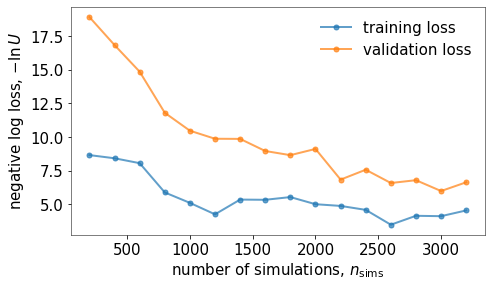

Population 16/31
Sampling proposal density...
Done.


Data Samples
[[ 8.86497893e+00  7.93808900e+00  1.05105809e+01 ... -6.61294929e+00
   1.09824271e-03 -3.90541753e-01]
 [ 8.86000272e+00  7.96802283e+00  1.05578104e+01 ... -6.58197324e+00
   1.09336021e-03 -3.89557848e-01]
 [ 8.84476307e+00  8.02113996e+00  1.05213150e+01 ... -6.60998021e+00
   1.09761466e-03 -3.87480251e-01]
 ...
 [ 8.86953985e+00  7.95315863e+00  1.04977952e+01 ... -6.60633568e+00
   1.09789045e-03 -3.88068808e-01]
 [ 8.81404401e+00  7.95192528e+00  1.05089801e+01 ... -6.50977471e+00
   1.10243808e-03 -3.87798865e-01]
 [ 8.87137814e+00  7.95285133e+00  1.05092414e+01 ... -6.60446899e+00
   1.09995116e-03 -3.90373315e-01]]
Parameter Samples
[[ 1.01036217e+01  1.02686944e+01  6.76458248e+00 ... -4.89468531e+00
   8.76354372e-04 -2.66939123e-01]
 [ 1.00626371e+01  1.01643274e+01  6.78998723e+00 ... -4.82951381e+00
   8.75384893e-04 -2.70443395e-01]
 [ 1.00626371e+01  1.01643274e+01  6.78998723e+00 ... -4.82951381e+00
   8.75384893e-04 -2.70443395e-01]
 ...
 [ 8.60356163

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.24864292,
        4.40310669,  4.20884991]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.30411053,
        8.30187607,  8.30000305]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.57696486,
        7.57304001,  7.56645632]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.50311565,
        6.49983311,  6.49319124]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.08642864,
        6.07889557,  6.07054853]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.62720156,
        5.6237278 ,  5.61570549])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.03073597,
        6.01100302,  5.84740591]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.72054005,
        9.71995068,  9.70838451]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.81995392,
        8.83501625,  8.82054901]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.17605829,
        7.16466045, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.24864292,
        4.40310669,  4.20884991]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.39342403,
        8.39222813,  8.39012146]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.57696486,
        7.57304001,  7.56645632]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.50311565,
        6.49983311,  6.49319124]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.08642864,
        6.07889557,  6.07054853]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.62720156,
        5.6237278 ,  5.61570549])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.03073597,
        6.01100302,  5.84740591]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.45499229,
        9.46961498,  9.4627161 ]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.81995392,
        8.83501625,  8.82054901]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.17605829,
        7.16466045, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.24864292,
        4.40310669,  4.20884991]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.39342403,
        8.39222813,  8.39012146]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.11390114,
        7.11261225,  7.1114831 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.50311565,
        6.49983311,  6.49319124]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.08642864,
        6.07889557,  6.07054853]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.62720156,
        5.6237278 ,  5.61570549])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.03073597,
        6.01100302,  5.84740591]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.45499229,
        9.46961498,  9.4627161 ]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.70248699,
        8.70787239,  8.7134943 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.17605829,
        7.16466045, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.24864292,
        4.40310669,  4.20884991]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.39342403,
        8.39222813,  8.39012146]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.11390114,
        7.11261225,  7.1114831 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.8357892 ,
        6.82519531,  6.82029724]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.08642864,
        6.07889557,  6.07054853]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.62720156,
        5.6237278 ,  5.61570549])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.03073597,
        6.01100302,  5.84740591]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.45499229,
        9.46961498,  9.4627161 ]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.70248699,
        8.70787239,  8.7134943 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.90045738,
        6.89565945, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.24864292,
        4.40310669,  4.20884991]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.39342403,
        8.39222813,  8.39012146]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.11390114,
        7.11261225,  7.1114831 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.8357892 ,
        6.82519531,  6.82029724]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.32409286,
        6.31996202,  6.31296539]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.62720156,
        5.6237278 ,  5.61570549])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.03073597,
        6.01100302,  5.84740591]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.45499229,
        9.46961498,  9.4627161 ]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.70248699,
        8.70787239,  8.7134943 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.90045738,
        6.89565945, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.24864292,
        4.40310669,  4.20884991]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.39342403,
        8.39222813,  8.39012146]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.11390114,
        7.11261225,  7.1114831 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.8357892 ,
        6.82519531,  6.82029724]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.32409286,
        6.31996202,  6.31296539]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.91630745,
        5.91295528,  5.90684509])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  6.03073597,
        6.01100302,  5.84740591]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.45499229,
        9.46961498,  9.4627161 ]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.70248699,
        8.70787239,  8.7134943 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.90045738,
        6.89565945, 

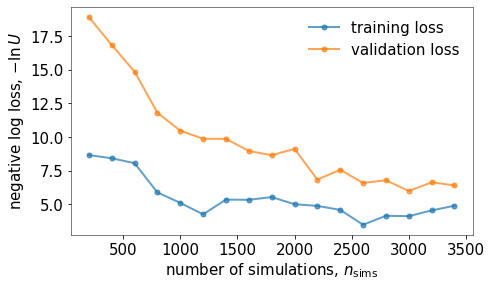

Population 17/31
Sampling proposal density...
Done.


Data Samples
[[ 8.80623947e+00  7.98466865e+00  1.05356017e+01 ... -6.60185141e+00
   1.10432574e-03 -3.89195555e-01]
 [ 8.92424881e+00  7.85488767e+00  1.05360720e+01 ... -6.60308345e+00
   1.10327863e-03 -3.89611597e-01]
 [ 8.83743100e+00  7.90369483e+00  1.05098599e+01 ... -6.61506858e+00
   1.09829471e-03 -3.87745434e-01]
 ...
 [ 8.83726567e+00  7.99334967e+00  1.04836613e+01 ... -6.57046174e+00
   1.10250735e-03 -3.91125925e-01]
 [ 8.85193737e+00  7.94652250e+00  1.05327514e+01 ... -6.67319130e+00
   1.10040504e-03 -3.91234561e-01]
 [ 8.87219569e+00  7.88014617e+00  1.05170247e+01 ... -6.66471337e+00
   1.09639074e-03 -3.90586495e-01]]
Parameter Samples
[[ 1.01657120e+01  8.64863315e+00  9.79472722e+00 ... -6.31871362e+00
   9.23091311e-04 -3.86337397e-01]
 [ 1.01657120e+01  8.64863315e+00  9.79472722e+00 ... -6.31871362e+00
   9.23091311e-04 -3.86337397e-01]
 [ 1.01657120e+01  8.64863315e+00  9.79472722e+00 ... -6.31871362e+00
   9.23091311e-04 -3.86337397e-01]
 ...
 [ 1.16234351

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.36653519,
        4.5138793 ,  4.35884333]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.39342403,
        8.39222813,  8.39012146]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.11390114,
        7.11261225,  7.1114831 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.8357892 ,
        6.82519531,  6.82029724]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.32409286,
        6.31996202,  6.31296539]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.91630745,
        5.91295528,  5.90684509])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  4.92806244,
        5.13711119,  5.04790258]), array([74.32527161, 73.75378418, 73.22917175, ...,  9.45499229,
        9.46961498,  9.4627161 ]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.70248699,
        8.70787239,  8.7134943 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.90045738,
        6.89565945, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.36653519,
        4.5138793 ,  4.35884333]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.5580616 ,
        8.55518627,  8.55348969]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.11390114,
        7.11261225,  7.1114831 ]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.8357892 ,
        6.82519531,  6.82029724]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.32409286,
        6.31996202,  6.31296539]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.91630745,
        5.91295528,  5.90684509])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  4.92806244,
        5.13711119,  5.04790258]), array([74.32527161, 73.75378418, 73.22917175, ...,  8.8938961 ,
        8.89720631,  8.90190983]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.70248699,
        8.70787239,  8.7134943 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.90045738,
        6.89565945, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.36653519,
        4.5138793 ,  4.35884333]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.5580616 ,
        8.55518627,  8.55348969]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.30715895,
        7.30606031,  7.30218458]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.8357892 ,
        6.82519531,  6.82029724]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.32409286,
        6.31996202,  6.31296539]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.91630745,
        5.91295528,  5.90684509])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  4.92806244,
        5.13711119,  5.04790258]), array([74.32527161, 73.75378418, 73.22917175, ...,  8.8938961 ,
        8.89720631,  8.90190983]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.17168617,
        8.15009403,  8.1676693 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  6.90045738,
        6.89565945, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.36653519,
        4.5138793 ,  4.35884333]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.5580616 ,
        8.55518627,  8.55348969]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.30715895,
        7.30606031,  7.30218458]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.96316195,
        6.95657539,  6.9534564 ]), array([47.02851105, 46.10498428, 45.21387482, ...,  6.32409286,
        6.31996202,  6.31296539]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.91630745,
        5.91295528,  5.90684509])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  4.92806244,
        5.13711119,  5.04790258]), array([74.32527161, 73.75378418, 73.22917175, ...,  8.8938961 ,
        8.89720631,  8.90190983]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.17168617,
        8.15009403,  8.1676693 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.35733652,
        7.35582352, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.36653519,
        4.5138793 ,  4.35884333]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.5580616 ,
        8.55518627,  8.55348969]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.30715895,
        7.30606031,  7.30218458]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.96316195,
        6.95657539,  6.9534564 ]), array([47.02851105, 46.10498428, 45.21387482, ...,  5.59182501,
        5.584939  ,  5.58309698]), array([42.83964157, 41.89914322, 41.00040054, ...,  5.91630745,
        5.91295528,  5.90684509])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  4.92806244,
        5.13711119,  5.04790258]), array([74.32527161, 73.75378418, 73.22917175, ...,  8.8938961 ,
        8.89720631,  8.90190983]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.17168617,
        8.15009403,  8.1676693 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.35733652,
        7.35582352, 

Training Loss
[array([18.32803345, 17.50069237, 16.8017025 , ...,  4.36653519,
        4.5138793 ,  4.35884333]), array([72.74679565, 72.16178131, 71.58900452, ...,  8.5580616 ,
        8.55518627,  8.55348969]), array([50.96737289, 49.98635483, 49.04163361, ...,  7.30715895,
        7.30606031,  7.30218458]), array([49.59289932, 48.69092941, 47.81535339, ...,  6.96316195,
        6.95657539,  6.9534564 ]), array([47.02851105, 46.10498428, 45.21387482, ...,  5.59182501,
        5.584939  ,  5.58309698]), array([42.83964157, 41.89914322, 41.00040054, ...,  6.17717361,
        6.16908026,  6.16532469])]
Val Loss
[array([19.66753197, 18.84279823, 18.14598846, ...,  4.92806244,
        5.13711119,  5.04790258]), array([74.32527161, 73.75378418, 73.22917175, ...,  8.8938961 ,
        8.89720631,  8.90190983]), array([51.81235504, 51.41046906, 50.99764252, ...,  8.17168617,
        8.15009403,  8.1676693 ]), array([54.71042633, 54.31807709, 53.92382812, ...,  7.35733652,
        7.35582352, 

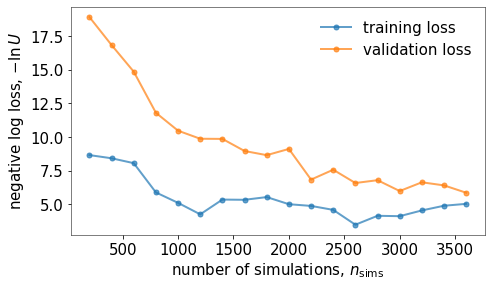

Population 18/31
Sampling proposal density...


In [ ]:
n_initial = 200
n_batch = 200
n_populations = 31

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=50., save_intermediate_posteriors=False, simulator_args = simulator_args, compressor_args = compressor_args)

## Sample the learned posterior

In [ ]:
from emcee.autocorr import integrated_time
#from emcee.moves import StretchMove

def emcee_sample(log_likelihood=None, x0=None, burn_in_chain=10, main_chain=10, nwalkers= 2000):

        # Set the log likelihood (default to the posterior if none given)
        if log_likelihood is None:
            log_likelihood = lambda x: DelfiEnsemble.log_posterior_stacked(x, DelfiEnsemble.data)[0]

        # Set up default x0
        if x0 is None:
            #x0 = emcee.utils.sample_ball(theta_fiducial, [0.01]*8 + [0.001] + [0.01], nwalkers)
            x0 = [DelfiEnsemble.posterior_samples[-i,:] for i in range(nwalkers)]

        # Set up the sampler
        sampler = emcee.EnsembleSampler(nwalkers, 10, log_likelihood)

        # Burn-in chain
        pos, prob, state = sampler.run_mcmc(x0, burn_in_chain)
        sampler.reset()

        sampler.run_mcmc(pos, main_chain)
        #print(sampler.acceptance_fraction)
        return sampler.flatchain


    

posterior_samples = emcee_sample(burn_in_chain=1000, main_chain=3000)

# acls = []
# for samps in posterior_samples:
#     acls.append(integrated_time(samps))
#     posterior_samples = posterior_samples[0:-1:int(np.max(acls)),:]

    
print(posterior_samples)
post = np.unique(posterior_samples, axis=0)
np.save('pst_samples.npy', post) # save

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:

posterior_samples = np.load('pst_samples.npy')
pst = np.unique(posterior_samples, axis=0)
print(pst.shape)
print(pst)
print(posterior_samples.shape)
DelfiEnsemble.triangle_plot(samples=[pst], savefig=True, filename='plot.pdf')

# param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']
# from IPython.display import display, Math
# params_med = []
# params_up = []
# params_low = []
# for i in range(10):
#     mcmc = np.percentile(posterior_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], param_names[i])
#     params_low.append(mcmc[1] - q[0])
#     params_med.append(mcmc[1])
#     params_up.append(mcmc[1] + q[1])
#     print(txt)


# plt.show()
# print(params_med)

## Plot learned log-likelihood vs squared error (proportional to Gaussian Likelihood)


In [ ]:
# post = np.load('pst_samples_whole_comp_fisher.npy')
# post = np.unique(post, axis=0)
# eps = [0]*94
# ll = lambda x: np.sum(np.sum((faasSimulator.data() - faasSimulator.forward(np.concatenate((x,eps)), seed))**2))

# ll_post = lambda x: DelfiEnsemble.log_likelihood_stacked(x, DelfiEnsemble.data)[0]

# # # pt_ll = [ll(i) for i in post]
# pt_ll_post = [ll_post(i) for i in post]
# #print(post.shape)
x = np.loadtxt(open('def.csv', "rb"), delimiter=',').T

plt.scatter(x[0], x[1])
plt.plot(np.unique(x[0]), np.poly1d(np.polyfit(x[0], x[1], 1))(np.unique(x[0])), color='red')
plt.xlabel("NDE log likelihood")
plt.ylabel("Squared Error")
plt.tight_layout()
plt.savefig('postvssquared_500.pdf')
plt.show()